## YouTube 眼中的你
- 專案目的/解決問題: 了解自己於YouTube平台的偏好，其中練習資料分析的能力。
- 需要技術: NLP、Time Series
- **最後記得整理一些function 到codebase**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
import nltk
import tensorflow as tf
from tensorflow import keras
from bs4 import BeautifulSoup
import os
import re
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']

In [3]:
os.listdir()

['.ipynb_checkpoints',
 'Takeout',
 'takeout-20211012T185843Z-001.zip',
 '專案：YouTube 眼中的你.ipynb']

In [4]:
os.listdir('Takeout/YouTube 和 YouTube Music/觀看記錄')

['search-history.html', 'watch-history.html']

In [5]:
# 先讀取.html data, 透過BeautifulSoup

data_dir = 'Takeout/YouTube 和 YouTube Music/觀看記錄'

# 轉成tree結構幫助搜尋資訊
with open(data_dir + '/watch-history.html', 'r', encoding='utf8') as f:
    soup_watch = BeautifulSoup(f.read(), 'html.parser')


In [6]:
# list of elements
watch_his = soup_watch.find_all(class_='content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1')

for e in watch_his:
    pprint(e)
    print(type(e))
    break

print(f'共有 {len(watch_his)} 筆 watched record')

<div class="content-cell mdl-cell mdl-cell--6-col mdl-typography--body-1">Watched <a href="https://www.youtube.com/watch?v=VwlVHa_5A6c">「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維</a><br/><a href="https://www.youtube.com/channel/UCcU6CC2Gkc18aBUfEtdjaAA">維思維WeisWay</a><br/>2021年9月21日 下午3:39:05 TST</div>
<class 'bs4.element.Tag'>
共有 2119 筆 watched record


In [7]:
# 繼續拆解出，url、影片名稱、頻道名稱、時間
import re

pprint(watch_his[0].find_all('a'))
print(watch_his[0].find_all('a')[0].string)
# 可以透過help更了解細節
print(watch_his[0].find_all('a')[0].get('href'))
print(watch_his[0].get_text())
print(watch_his[0].find_all(string=re.compile('TST')))

[<a href="https://www.youtube.com/watch?v=VwlVHa_5A6c">「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維</a>,
 <a href="https://www.youtube.com/channel/UCcU6CC2Gkc18aBUfEtdjaAA">維思維WeisWay</a>]
「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維
https://www.youtube.com/watch?v=VwlVHa_5A6c
Watched 「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維維思維WeisWay2021年9月21日 下午3:39:05 TST
['2021年9月21日 下午3:39:05 TST']


In [8]:
for e in watch_his:
    watch_title, watch_channel = e.find_all('a')
    url = watch_title.get('href')
    watch_title = watch_title.string
    watch_channel_url = watch_channel.get('href')
    watch_channel = watch_channel.string
    timestamp = e.find(string=re.compile('TST'))
    
    print(watch_title, url)
    print(watch_channel, watch_channel_url)
    print(timestamp)
    print()
    break

「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維 https://www.youtube.com/watch?v=VwlVHa_5A6c
維思維WeisWay https://www.youtube.com/channel/UCcU6CC2Gkc18aBUfEtdjaAA
2021年9月21日 下午3:39:05 TST



In [9]:
# 轉換成.csv檔案方便處理

df = pd.DataFrame(columns=['watch_title', 'watch_title_url', 'watch_channel', 'watch_channel_url', 'watch_time_stamp'])

for e in watch_his:
    if len(e.find_all('a')) < 2:
        continue
    #print(e)
    #print()
    watch_title, watch_channel = e.find_all('a')
    url = watch_title.get('href')
    watch_title = watch_title.string
    watch_channel_url = watch_channel.get('href')
    watch_channel = watch_channel.string
    timestamp = e.find(string=re.compile('TST'))
    
    df = df.append({'watch_title': watch_title, 'watch_title_url': url, 'watch_channel':  watch_channel, 'watch_channel_url': watch_channel_url, 'watch_time_stamp': timestamp}, ignore_index=True)

    
df.head()

,watch_title,watch_title_url,watch_channel,watch_channel_url,watch_time_stamp
0,「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維,https://www.youtube.com/watch?v=VwlVHa_5A6c,維思維WeisWay,https://www.youtube.com/channel/UCcU6CC2Gkc18a...,2021年9月21日 下午3:39:05 TST
1,你也曾經使用過的「操控術」讓人無意識的「自動順從」？無形的操控心理學！【心理學】 | 維思維,https://www.youtube.com/watch?v=CNcvlBhwrOg,維思維WeisWay,https://www.youtube.com/channel/UCcU6CC2Gkc18a...,2021年9月21日 下午3:38:13 TST
2,老婆和老公吵架，老公播放在講奶子的惡搞歌曲成功逗笑老婆 (中文字幕),https://www.youtube.com/watch?v=eYWWlM6JaRQ,B.C.&Lowy,https://www.youtube.com/channel/UCRrOsab_je2oA...,2021年9月21日 下午3:37:01 TST
3,How I'm figuring out what to do with my life,https://www.youtube.com/watch?v=qSlGASiJV_4,Tina Huang,https://www.youtube.com/channel/UC2UXDak6o7rBm...,2021年9月21日 下午3:35:55 TST
4,【打電話的時候稱呼另一半為朋友】,https://www.youtube.com/watch?v=RWsDkpai3IE,鬥士工作室Fighter Studio Hk,https://www.youtube.com/channel/UCMH-zQFPAxTwk...,2021年9月21日 下午3:34:43 TST


In [10]:
df

,watch_title,watch_title_url,watch_channel,watch_channel_url,watch_time_stamp
0,「你的筆跡」已暴露你真實個性人格！神奇的筆跡心理學【心理學】 | 維思維,https://www.youtube.com/watch?v=VwlVHa_5A6c,維思維WeisWay,https://www.youtube.com/channel/UCcU6CC2Gkc18a...,2021年9月21日 下午3:39:05 TST
1,你也曾經使用過的「操控術」讓人無意識的「自動順從」？無形的操控心理學！【心理學】 | 維思維,https://www.youtube.com/watch?v=CNcvlBhwrOg,維思維WeisWay,https://www.youtube.com/channel/UCcU6CC2Gkc18a...,2021年9月21日 下午3:38:13 TST
2,老婆和老公吵架，老公播放在講奶子的惡搞歌曲成功逗笑老婆 (中文字幕),https://www.youtube.com/watch?v=eYWWlM6JaRQ,B.C.&Lowy,https://www.youtube.com/channel/UCRrOsab_je2oA...,2021年9月21日 下午3:37:01 TST
3,How I'm figuring out what to do with my life,https://www.youtube.com/watch?v=qSlGASiJV_4,Tina Huang,https://www.youtube.com/channel/UC2UXDak6o7rBm...,2021年9月21日 下午3:35:55 TST
4,【打電話的時候稱呼另一半為朋友】,https://www.youtube.com/watch?v=RWsDkpai3IE,鬥士工作室Fighter Studio Hk,https://www.youtube.com/channel/UCMH-zQFPAxTwk...,2021年9月21日 下午3:34:43 TST
...,...,...,...,...,...
2003,Scikit-Learn 3 如何选择机器学习方法 (机器学习 sklearn 教学教程tu...,https://www.youtube.com/watch?v=GB8SNR-cT7w,莫烦Python,https://www.youtube.com/channel/UCdyjiB5H8Pu7a...,2019年9月8日 下午11:57:31 TST
2004,Scikit-Learn 2 安装 (机器学习 sklearn 教学教程tutorial),https://www.youtube.com/watch?v=FG3W1_8ogBE,莫烦Python,https://www.youtube.com/channel/UCdyjiB5H8Pu7a...,2019年9月8日 下午11:57:14 TST
2005,Scikit-Learn 1 Why? (机器学习 sklearn 教学教程tutorial),https://www.youtube.com/watch?v=7wWMP2elSvE,莫烦Python,https://www.youtube.com/channel/UCdyjiB5H8Pu7a...,2019年9月8日 下午11:56:50 TST
2006,什么是机器学习? What is machine learning?,https://www.youtube.com/watch?v=YY7-VKXybjc,莫烦Python,https://www.youtube.com/channel/UCdyjiB5H8Pu7a...,2019年9月8日 下午11:56:42 TST


> 哪些問題可以幫助我了解自己的習慣?

> 有一些分析問題是可以用SQL直接解決的?

## 觀看內容與訂閱頻道的關係
1. 有多少比例是訂閱頻道的內容?

> 搭配 YouTube API / Selenium 取得頻道/影片圖片。

In [11]:
df_subs = pd.read_csv('Takeout/YouTube 和 YouTube Music/訂閱內容/訂閱內容.csv')
channels = set(df_subs['頻道名稱'])
del df_subs


channels

{'365 Data Science',
 'AWS Events',
 'Aoxiang Cui',
 'CS Dojo',
 'CS50',
 'Chimi & John',
 'Coding Tech',
 'Cupoy AI知識特助',
 'DATAcated',
 'DIGI Bigdata',
 'Data Interview Pro',
 'Data Professor',
 'Data School',
 'DeepLearningAI',
 'Errichto',
 'Google',
 'Google Career Certificates',
 'Google Developers Taiwan - Google 開發人員台灣頻道',
 'Google Students',
 'Greg Hogg',
 'HackBear 泰瑞',
 'HackerRank',
 'House of El',
 'Hung-yi Lee',
 'Joma Tech',
 'Ken Jee',
 'Kylie Ying',
 'Life at Google',
 'Mark Chang',
 'Microsoft Research',
 'NYC Data Science Academy',
 'Nick White',
 'Open Data Science',
 'PhD and Productivity',
 'SITCON 學生計算機年會',
 'Siraj Raval',
 'Springboard',
 'The Coding Train',
 'Tina Huang',
 'Traversy Media',
 'Vivian NTU MiuLab',
 'Web Dev Simplified',
 'William Lin',
 'Women in Data Science Bogota',
 'Yacine Mahdid',
 'Yen-Lung Tsai',
 'freeCodeCamp.org',
 'mayuko',
 'stanfordonline',
 'the roadmap',
 '哈佛姐夢遊矽谷 AliceInSiliconWonderland',
 '啃芝士',
 '土妹土妹',
 '大數軟體有限公司',
 '小巧小马',
 '

([<matplotlib.patches.Wedge at 0x1cbfcec4748>,
 [Text(0.667815629542845, 0.8740836830294304, '訂閱影片 28.999999999999996%'),
  Text(-0.6678156295428449, -0.8740836830294305, '非訂閱影片 71.0%')])

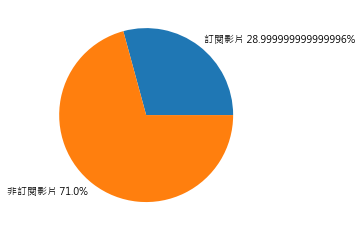

In [12]:
# 透過isin判斷是否為頻道內

num_in_channels = sum(df['watch_channel'].isin(channels))
num_not_in_channels = len(df) - num_in_channels
in_ratio = round(num_in_channels / len(df), 2) * 100
not_in_ratio = round(num_not_in_channels / len(df), 2) * 100

plt.pie(x=[num_in_channels, num_not_in_channels], labels=[f'訂閱影片 {in_ratio}%', f'非訂閱影片 {not_in_ratio}%'])

<BarContainer object of 2 artists>

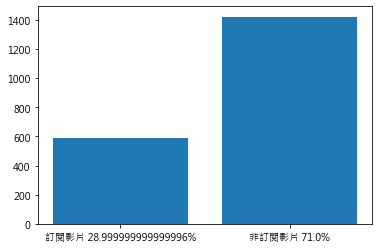

In [13]:
plt.bar(x=[f'訂閱影片 {in_ratio}%', f'非訂閱影片 {not_in_ratio}%'], height=[num_in_channels, num_not_in_channels])

### 細看每一個頻道的觀看數

In [17]:
counter = {}

for e in df['watch_channel']:
    if e not in counter:
        counter[e] = 1
    else:
        counter[e] += 1

counter = sorted(counter.items(), key=lambda x: x[1], reverse=True)
counter[:20]

[('Hung-yi Lee', 173),
 ('B.C.&Lowy', 142),
 ('鬥士工作室Fighter Studio Hk', 112),
 ('莫烦Python', 65),
 ('ETtoday星光雲/官方平台', 40),
 ('Clément Mihailescu', 37),
 ('Jack Chou', 36),
 ('Joma Tech', 36),
 ('Tina Huang', 29),
 ('mayuko', 29),
 ('Slick Production', 28),
 ('NBA BTF Shorts', 21),
 ('Cupoy AI知識特助', 21),
 ('音樂家小舖', 20),
 ('Aaron Yang', 20),
 ('Highlight NBA', 18),
 ('TSNA', 18),
 ('Ken Jee', 18),
 ('Springboard', 18),
 ('William Lin', 18)]

Text(0.5, 1.0, '頻道影片觀看數')

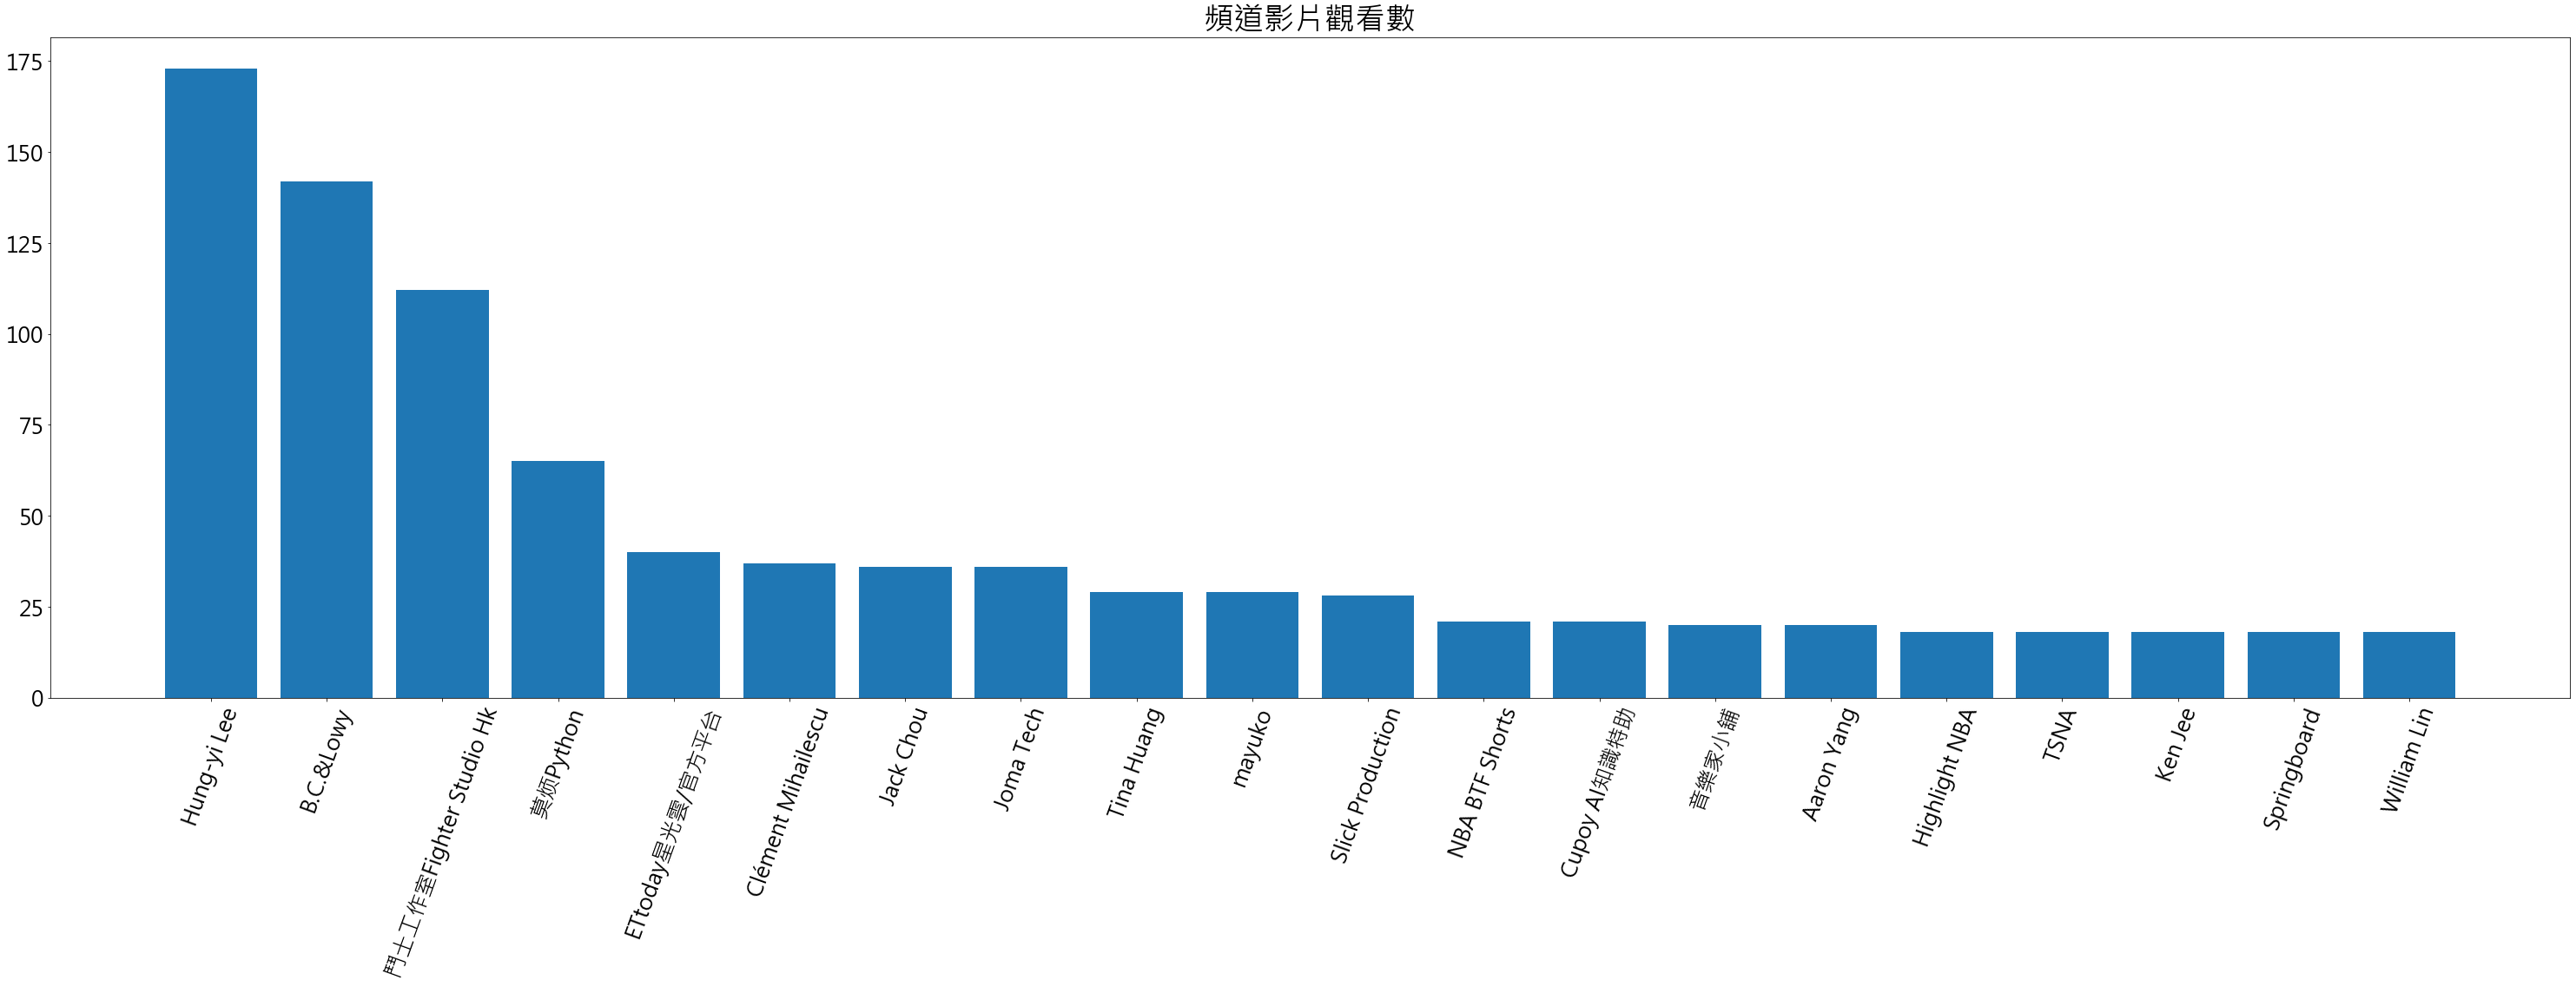

In [15]:
# Top 20

plt.figure(figsize=(52, 14))
parameters = {'axes.labelsize': 25,
              'xtick.labelsize': 25,
              'ytick.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)
plt.bar(x=[e[0] for e in counter[:20]], height=[e[1] for e in counter[:20]])
plt.xticks(rotation=70)
plt.title('頻道影片觀看數')

### 看訂閱與非訂閱的Top 20

Text(0.5, 1.0, '非訂閱頻道影片觀看數 Top 20')

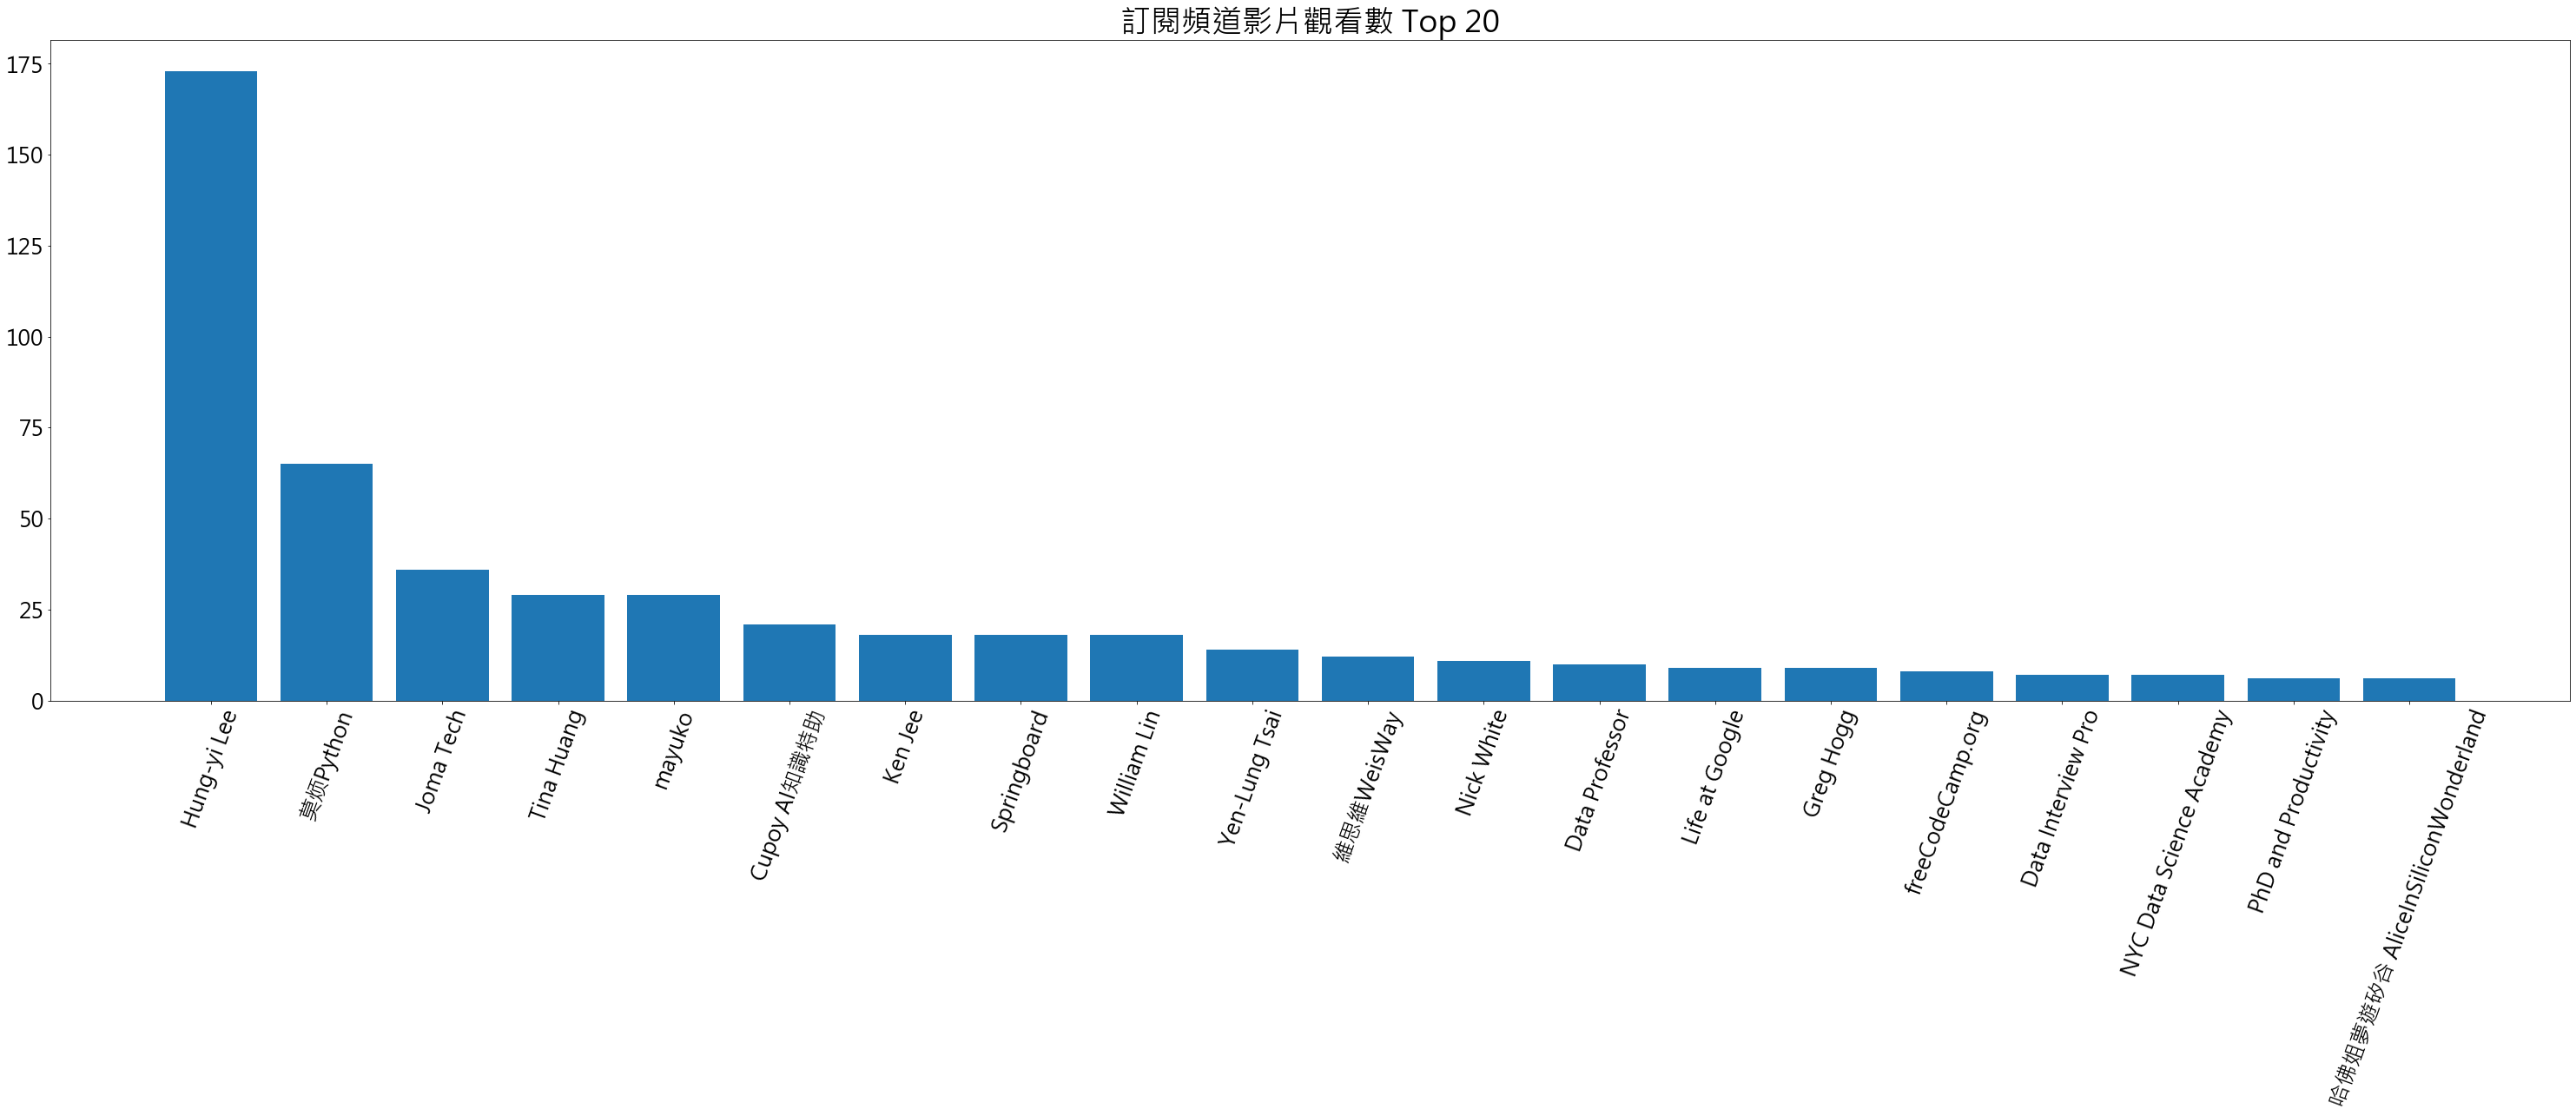

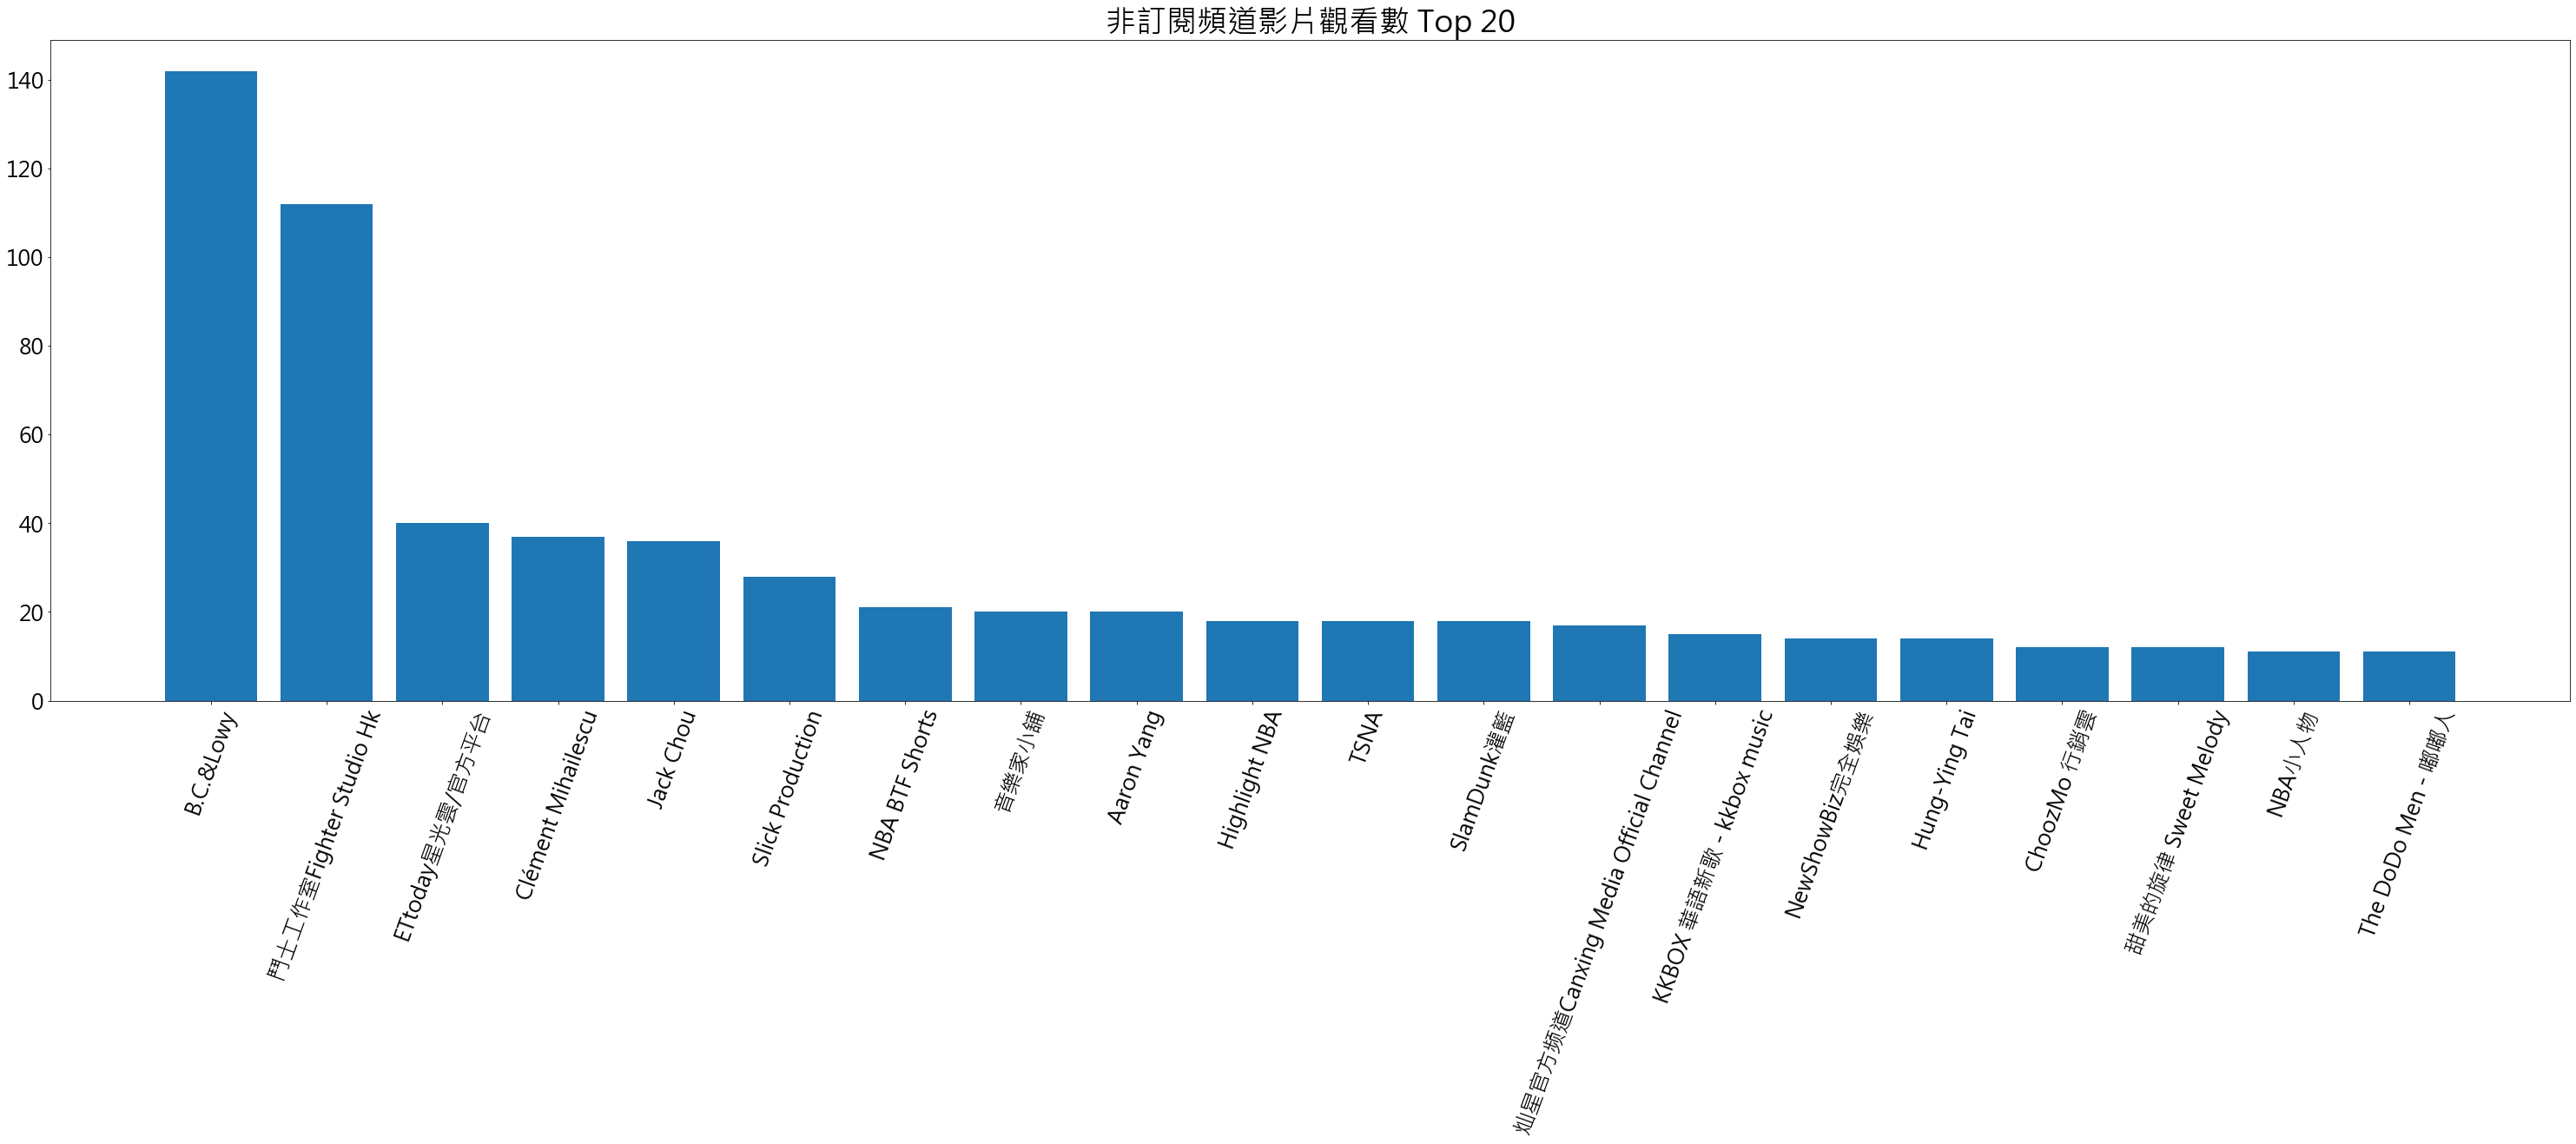

In [21]:
counter_not_in_channel = {}
counter_in_channel = {}

for e in df['watch_channel']:
    if e not in channels:
        if e not in counter_not_in_channel:
            counter_not_in_channel[e] = 1
        else:
            counter_not_in_channel[e] += 1
    else:
        if e not in counter_in_channel:
            counter_in_channel[e] = 1
        else:
            counter_in_channel[e] += 1

# sort
counter_not_in_channel = sorted(counter_not_in_channel.items(), key=lambda x: x[1], reverse=True)
counter_in_channel = sorted(counter_in_channel.items(), key=lambda x: x[1], reverse=True)

# in-channel
plt.figure(figsize=(52, 14))
parameters = {'axes.labelsize': 25,
              'xtick.labelsize': 25,
              'ytick.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)
plt.bar(x=[e[0] for e in counter_in_channel[:20]], height=[e[1] for e in counter_in_channel[:20]])
plt.xticks(rotation=70)
plt.title('訂閱頻道影片觀看數 Top 20')

# out-channel
plt.figure(figsize=(52, 14))
parameters = {'axes.labelsize': 25,
              'xtick.labelsize': 25,
              'ytick.labelsize': 25,
          'axes.titlesize': 35}
plt.rcParams.update(parameters)
plt.bar(x=[e[0] for e in counter_not_in_channel[:20]], height=[e[1] for e in counter_not_in_channel[:20]])
plt.xticks(rotation=70)
plt.title('非訂閱頻道影片觀看數 Top 20')

## 從非訂閱/訂閱頻道 Top 20發現
- 訂閱頻道觀看次數高基本上皆為程式相關頻道
- 非訂閱頻道觀看次數高基本上為搞笑相關頻道，夾雜籃球、音樂
- 兩者分配皆為高度集中某幾個頻道。

## 透過文字雲觀察容易吸引我的標題
- 將所有標題合併